# 고혈압 분석 모델
## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer


In [ ]:
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/year0_NA.csv', index_col=0, na_values=['NA'])

dataset = dataset.drop(['AS1_TOTALC'], axis=1) # AS1_TOTALC 열 제거
idx_dataset = list(dataset.index)
col_dataset = list(dataset.columns)
dataset

,AS1_SEX,AS1_AGE,AS1_JOBB,AS1_EDUA,AS1_INCOME,AS1_DRINK,AS1_DRDUA,AS1_SMOKEA,AS1_HVSMAM,AS1_HVSMDU,AS1_PHYSTB,AS1_PHYSIT,AS1_PHYACTL,AS1_PHYACTM,AS1_PHYACTH,AS1_INSUR,AS1_HEALTH,AS0_TIED,AS1_SLPAMTM,AS0_SLPAMSF,AS1_STRPHYSJ,AS1_RGMEALFQA,AS1_HEIGHT,AS1_WEIGHT,AS1_B01,AS1_B02,AS1_B03,AS1_B04,AS1_B05,AS1_B06,AS1_B07,AS1_B08,AS1_B09,AS1_B10,AS1_B11,AS1_B12,AS1_B13,AS1_B14,AS1_B15,AS1_B16,AS1_B17,AS1_B18,AS1_B19,AS1_B20,AS1_B21,AS1_B23,AS1_B24,P1,P2,P3,P4,HYPERTENSION
RID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
EPI20_026_2_000001,1,69,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,2.0,0.0,0.0,3.0,2.0,1.0,9.0,1.0,1,3.0,NaN,NaN,2140,78,39,371,640,1316,13,3244,807,4440,2,1,14,128,9,2,380,76,4323,27,11,9,145,65,67,965,200,1
EPI20_026_2_000002,0,66,3.0,1.0,1.0,3.0,5.0,3.0,20.0,45.0,0.0,3.0,6.0,1.0,7.0,2.0,2.0,NaN,7.0,1.0,0,3.0,NaN,NaN,1533,48,22,277,269,698,7,1461,171,1546,1,1,12,53,7,1,124,29,778,9,4,6,94,56,75,735,42,0
EPI20_026_2_000003,0,63,7.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,1.0,2.0,4.0,0.0,7.0,1.0,0,3.0,159.0,66.0,1308,32,11,263,226,521,5,1214,342,2533,1,1,7,53,4,1,136,13,2045,11,4,4,29,12,34,862,19,1
EPI20_026_2_000004,1,56,8.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,2.0,6.0,6.0,3.0,8.0,2.0,4.0,1.0,7.0,1.0,0,3.0,NaN,68.0,2649,79,38,494,522,1155,15,3403,640,2574,2,1,20,264,16,2,350,101,3171,18,9,13,335,702,75,735,82,1
EPI20_026_2_000005,0,42,3.0,3.0,5.0,2.0,3.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0,8.0,2.0,2.0,1.0,8.0,1.0,1,3.0,NaN,NaN,2638,76,31,506,333,1213,14,2645,310,2156,2,1,19,138,10,2,276,23,1677,17,9,10,111,470,10,1070,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPI20_026_2_010026,1,41,4.0,3.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,0.0,2.0,3.0,1.0,5.0,0.0,0,3.0,165.0,60.0,1975,76,43,313,523,1119,11,2178,399,1338,1,1,17,72,10,2,181,82,1740,12,5,9,210,30,85,680,290,0
EPI20_026_2_010027,1,53,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,6.0,0.0,0.0,2.0,4.0,0.0,7.0,0.0,0,3.0,NaN,57.0,1431,41,15,276,264,620,6,1288,236,1441,1,1,9,61,7,1,135,39,1152,9,3,5,87,22,30,735,15,1
EPI20_026_2_010028,0,40,4.0,3.0,5.0,3.0,5.0,1.0,0.0,0.0,3.0,8.0,0.0,0.0,0.0,2.0,3.0,1.0,8.0,1.0,1,3.0,NaN,73.0,1988,71,41,326,460,1050,11,2317,657,1693,2,1,20,136,9,2,247,145,3333,13,6,10,170,2,66,730,114,0


### dataset 결측값 채우기

In [ ]:
# dataset에 있는 변수 분리, 범주형, 연속형 등으로 분리하여 각각 정규화한다.

raw_dataset = dataset.drop(columns=['AS1_SEX', 'AS0_TIED', 'AS0_SLPAMSF', 'AS1_STRPHYSJ',
                                'AS1_JOBB', 'AS1_INSUR'])
col_raw = list(raw_dataset.columns)

dropped = dataset[['AS1_SEX', 'AS0_TIED', 'AS0_SLPAMSF', 'AS1_STRPHYSJ',
                   'AS1_JOBB', 'AS1_INSUR']]

print(raw_dataset.describe, dropped.describe)
            

<bound method NDFrame.describe of                     AS1_AGE  AS1_EDUA  AS1_INCOME  ...    P3   P4  HYPERTENSION
RID                                                ...                         
EPI20_026_2_000001       69       1.0         3.0  ...   965  200             1
EPI20_026_2_000002       66       1.0         1.0  ...   735   42             0
EPI20_026_2_000003       63       5.0         3.0  ...   862   19             1
EPI20_026_2_000004       56       1.0         4.0  ...   735   82             1
EPI20_026_2_000005       42       3.0         5.0  ...  1070   14             0
...                     ...       ...         ...  ...   ...  ...           ...
EPI20_026_2_010026       41       3.0         6.0  ...   680  290             0
EPI20_026_2_010027       53       2.0         4.0  ...   735   15             1
EPI20_026_2_010028       40       3.0         5.0  ...   730  114             0
EPI20_026_2_010029       53       1.0         2.0  ...   960   15             0
EPI20_

In [ ]:
imputer = KNNImputer(n_neighbors=5)
filled_dataset = pd.DataFrame(imputer.fit_transform(raw_dataset),
                              index=idx_dataset, columns=col_raw)

In [ ]:
df = pd.concat([dropped, filled_dataset], axis=1).dropna()
df.describe

<bound method NDFrame.describe of                     AS1_SEX  AS0_TIED  AS0_SLPAMSF  ...      P3     P4  HYPERTENSION
RID                                                 ...                             
EPI20_026_2_000001        1       1.0          1.0  ...   965.0  200.0           1.0
EPI20_026_2_000003        0       0.0          1.0  ...   862.0   19.0           1.0
EPI20_026_2_000004        1       1.0          1.0  ...   735.0   82.0           1.0
EPI20_026_2_000005        0       1.0          1.0  ...  1070.0   14.0           0.0
EPI20_026_2_000006        1       1.0          0.0  ...   705.0  561.0           1.0
...                     ...       ...          ...  ...     ...    ...           ...
EPI20_026_2_010026        1       1.0          0.0  ...   680.0  290.0           0.0
EPI20_026_2_010027        1       0.0          0.0  ...   735.0   15.0           1.0
EPI20_026_2_010028        0       1.0          1.0  ...   730.0  114.0           0.0
EPI20_026_2_010029        0    

### dataset 결측값 제거

In [ ]:
df = dataset.dropna()
df.describe

<bound method NDFrame.describe of                     AS1_SEX  AS1_AGE  AS1_JOBB  ...   P3   P4  HYPERTENSION
RID                                             ...                        
EPI20_026_2_000007        0       56       4.0  ...  840   20             0
EPI20_026_2_000009        1       47       1.0  ...  836   45             0
EPI20_026_2_000010        0       50       6.0  ...  990   14             0
EPI20_026_2_000032        1       69       1.0  ...  745   17             1
EPI20_026_2_000043        1       45       1.0  ...  935  210             0
...                     ...      ...       ...  ...  ...  ...           ...
EPI20_026_2_010014        0       47       4.0  ...  865  127             1
EPI20_026_2_010015        0       48       8.0  ...  821  340             0
EPI20_026_2_010018        0       47       4.0  ...  813    5             0
EPI20_026_2_010022        0       40       8.0  ...  835  320             0
EPI20_026_2_010026        1       41       4.0  ...  6

### dataset 분리, 정규화
- train, test

In [ ]:
# df에 있는 변수 분리, 범주형, 연속형 등으로 분리하여 각각 정규화한다.

# 범주형(binary, 0 or 1)
binary = df.reindex(columns=['AS1_SEX', 'AS0_TIED', 'AS0_SLPAMSF', 'AS1_STRPHYSJ'])
binary = binary.astype('int')

#범주형(계층 없음, with hierarchy)
categoryH0 = df.reindex(columns=['AS1_JOBB', 'AS1_INSUR'])
categoryH0 = pd.get_dummies(categoryH0, columns=['AS1_JOBB', 'AS1_INSUR']) # one-hot-encoding

# 범주형(계층 있음, without hierarchy)
categoryH1 = df.reindex(columns=['AS1_EDUA', 'AS1_INCOME', 'AS1_DRINK', 'AS1_DRDUA',
                                 'AS1_SMOKEA', 'AS1_PHYSTB', 'AS1_PHYSIT', 'AS1_PHYACTL',
                                 'AS1_PHYACTM', 'AS1_PHYACTH', 'AS1_HEALTH'
                                 ])

# 연속형 변수
ctn = df.reindex(columns=['AS1_AGE', 'AS1_HVSMAM', 'AS1_HVSMDU', # 'AS1_TOTALC', 제거
                          'AS1_SLPAMTM', 'AS1_RGMEALFQA', 'AS1_HEIGHT', 'AS1_WEIGHT',
                          'AS1_B01', 'AS1_B02', 'AS1_B03', 'AS1_B04', 'AS1_B05',
                          'AS1_B06', 'AS1_B07', 'AS1_B08', 'AS1_B09', 'AS1_B10',
                          'AS1_B11', 'AS1_B12', 'AS1_B13', 'AS1_B14', 'AS1_B15',
                          'AS1_B16', 'AS1_B17', 'AS1_B18', 'AS1_B19', 'AS1_B20',
                          'AS1_B21', 'AS1_B23', 'AS1_B24', 'P1', 'P2', 'P3', 'P4'
                          ])

In [ ]:
# category_h1, ctn 정규화
# train만으로 scale 해야하는가? 교수님에게 질문해보기

scaler0 = StandardScaler()
scaler1 = MinMaxScaler()
scaler2 = QuantileTransformer()

def standard(category, ctn):
  colList_category = list(category.columns)
  colList_ctn = list(ctn.columns)
  category[colList_category] = scaler0.fit_transform(category)
  ctn[colList_ctn] = scaler0.fit_transform(ctn)

  return category, ctn


def minmax(category, ctn):
  colList_category = list(category.columns)
  colList_ctn = list(ctn.columns)
  category[colList_category] = scaler1.fit_transform(category)
  ctn[colList_ctn] = scaler1.fit_transform(ctn)

  return category, ctn


def quantile(category, ctn):
  colList_category = list(category.columns)
  colList_ctn = list(ctn.columns)
  category[colList_category] = scaler2.fit_transform(category)
  ctn[colList_ctn] = scaler2.fit_transform(ctn)

  return category, ctn


In [ ]:
# categoryH1, ctn = standard(categoryH1, ctn)
# categoryH1, ctn = minmax(categoryH1, ctn)
categoryH1, ctn = quantile(categoryH1, ctn)

X = pd.concat([binary, categoryH0, categoryH1, ctn], axis=1)
y = df['HYPERTENSION']  # 고혈압 변수

# 훈련 데이터 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6673, 61) (2861, 61) (6673,) (2861,)


In [ ]:
X_train

,AS1_SEX,AS0_TIED,AS0_SLPAMSF,AS1_STRPHYSJ,AS1_JOBB_0.0,AS1_JOBB_1.0,AS1_JOBB_2.0,AS1_JOBB_3.0,AS1_JOBB_4.0,AS1_JOBB_5.0,AS1_JOBB_6.0,AS1_JOBB_7.0,AS1_JOBB_8.0,AS1_INSUR_1.0,AS1_INSUR_2.0,AS1_INSUR_3.0,AS1_EDUA,AS1_INCOME,AS1_DRINK,AS1_DRDUA,AS1_SMOKEA,AS1_PHYSTB,AS1_PHYSIT,AS1_PHYACTL,AS1_PHYACTM,AS1_PHYACTH,AS1_HEALTH,AS1_AGE,AS1_HVSMAM,AS1_HVSMDU,AS1_SLPAMTM,AS1_RGMEALFQA,AS1_HEIGHT,AS1_WEIGHT,AS1_B01,AS1_B02,AS1_B03,AS1_B04,AS1_B05,AS1_B06,AS1_B07,AS1_B08,AS1_B09,AS1_B10,AS1_B11,AS1_B12,AS1_B13,AS1_B14,AS1_B15,AS1_B16,AS1_B17,AS1_B18,AS1_B19,AS1_B20,AS1_B21,AS1_B23,AS1_B24,P1,P2,P3,P4
RID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
EPI20_026_2_008393,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.000000,0.427427,1.0,1.0,1.000000,0.000000,0.165165,0.445946,0.000000,0.000000,0.518018,0.620621,0.998395,0.914414,0.567568,0.563063,0.844344,0.791792,0.810964,0.892893,0.826326,0.796797,0.963529,0.909612,0.930931,0.915728,0.931195,0.963622,0.858859,0.931932,0.906907,0.700701,0.893393,0.912913,0.971335,0.191692,0.942062,0.926927,0.784785,0.689690,0.697698,0.863864,0.973307,0.492970,0.805305
EPI20_026_2_000583,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0.713213,0.000000,1.0,1.0,1.000000,0.000000,0.165165,0.000000,0.000000,1.000000,0.518018,0.565566,0.966466,0.940440,0.816316,0.563063,0.116116,0.347848,0.120120,0.075576,0.039540,0.197197,0.039039,0.108108,0.126627,0.118452,0.066066,0.127149,0.389890,0.000000,0.114615,0.056056,0.103604,0.004004,0.053053,0.143644,0.068735,0.047548,0.155656,0.026527,0.020020,0.072072,0.421922,0.464965,0.294294
EPI20_026_2_007110,1,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0.713213,0.737237,0.0,0.0,0.000000,0.544044,0.165165,0.445946,0.000000,0.000000,0.041041,0.184685,0.000000,0.000000,0.816316,0.563063,0.217217,0.138639,0.353569,0.384384,0.255255,0.429930,0.555556,0.496496,0.494995,0.535434,0.687688,0.532533,0.389890,0.109610,0.394394,0.569069,0.362863,0.399900,0.611612,0.455956,0.732056,0.448949,0.663163,0.364364,0.413413,0.285285,0.069069,0.703203,0.500000
EPI20_026_2_009670,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.943944,0.737237,1.0,1.0,0.665165,1.000000,1.000000,0.616116,0.000000,0.663664,0.518018,0.130631,0.000000,0.000000,0.985485,0.563063,0.832332,0.733734,0.570571,0.667167,0.618118,0.521522,0.709209,0.550551,0.736236,0.612187,0.892496,0.754082,0.389890,0.109610,0.720721,0.583584,0.733233,0.399900,0.792292,0.455956,0.915784,0.720220,0.663163,0.638138,0.496997,0.563564,0.434434,0.623123,0.628629
EPI20_026_2_002832,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.000000,0.269269,1.0,1.0,0.000000,0.322322,0.000000,0.616116,0.904404,1.000000,0.518018,0.847848,0.000000,0.000000,0.567568,0.563063,0.696196,0.092593,0.779780,0.745245,0.582082,0.819820,0.501001,0.645646,0.839840,0.704496,0.800300,0.548549,0.858859,0.109610,0.665165,0.823824,0.857357,0.912913,0.792292,0.133133,0.839171,0.823824,0.663163,0.565065,0.225225,0.897449,0.774775,0.764765,0.520020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPI20_026_2_007766,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0.713213,0.577578,0.0,0.0,0.000000,0.000000,0.360861,0.616116,0.561562,0.729229,0.518018,0.330831,0.000000,0.000000,0.567568,0.563063,0.409409,0.439940,0.455543,0.543043,0.559560,0.402402,0.594595,0.576577,0.396897,0.608032,0.477477,0.661888,0.389890,0.109610,0.468468,0.394394,0.506006,0.399900,0.669169,0.624625,0.481815,0.395896,0.578579,0.565065,0.469970,0.314815,0.598098,0.722222,0.845846
EPI20_026_2_008163,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0.883884,0.269269,0.0,0.0,1.000000,0.544044,0.604605,0.721221,0.666667,0.000000,0.041041,0.130631,0.804805,0.748248,0.947447,0.563063,0.945445,0.154655,0.873702,0.828829,0.483984,0.908909,0.296296,0.814159,0.668168,0.556557,0.559560,0.477845,0.389890,0.109610,0.808809,0.320320,0.806807,0.399900,0.719720,0.370370,0.561445,0.395896,0.663163,0.468468,0.527528,0.668

### 모델 제작

In [ ]:
import IPython

!pip install -U keras-tuner
import kerastuner as kt

In [ ]:
from kerastuner import HyperModel

class RegressionHyperModel(HyperModel):
  def __init__(self, input_shape):
    self.input_shape = input_shape

def model_builder(hp):
  model = Sequential()
  # model.add(Dense(12, input_dim=61, activation='relu'))

  # # Tune the number of units in the first Dense layer
  # # Choose an optimal value between 32-512
  # hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)

  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)

  model.add(Dense(units = hp_units,
                  activation='relu',
                  input_shape=input_shape)) # input_dim
        
  model.add(Dense(units = hp_units,
                  activation='relu'))
  
  model.add(Dense(units = hp_units,
                  activation='relu'))
  
  model.add(Dense(units = hp_units,
                  activation='relu'))
        
  model.add(Dropout(hp.Float('dropout',
                              min_value=0.0,
                              max_value=0.1,
                              default=0.005,
                              step=0.01)))
        
  model.add(Dense(1, activation='sigmoid')) # 출력층

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                # loss="binary_crossentropy",
                metrics = ['accuracy'])
  # model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
  
  return model

In [ ]:
input_shape = (X_train.shape[1],)
hypermodel = RegressionHyperModel(input_shape)

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'HyperTension_sh22h') 

In [ ]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 12 Complete [00h 00m 04s]
val_accuracy: 0.7721076607704163

Best val_accuracy So Far: 0.7759524583816528
Total elapsed time: 00h 01m 32s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.0001.



In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test))
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Epoch 1/10
209/209 [==============================] - 1s 3ms/step - loss: 0.5281 - accuracy: 0.7638 - val_loss: 0.5081 - val_accuracy: 0.7700
Epoch 2/10
209/209 [==============================] - 1s 3ms/step - loss: 0.5056 - accuracy: 0.7652 - val_loss: 0.5353 - val_accuracy: 0.7452
Epoch 3/10
209/209 [==============================] - 0s 2ms/step - loss: 0.5022 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.7676
Epoch 4/10
209/209 [==============================] - 0s 2ms/step - loss: 0.4982 - accuracy: 0.7676 - val_loss: 0.5155 - val_accuracy: 0.7606
Epoch 5/10
209/209 [==============================] - 1s 2ms/step - loss: 0.4915 - accuracy: 0.7665 - val_loss: 0.5094 - val_accuracy: 0.7711
Epoch 6/10
209/209 [==============================] - 0s 2ms/step - loss: 0.4860 - accuracy: 0.7722 - val_loss: 0.5127 - val_accuracy: 0.7686
Epoch 7/10
209/209 [==============================] - 1s 3ms/step - loss: 0.4821 - accuracy: 0.7722 - val_loss: 0.5104 - val_accuracy: 0.7627
Epoch 

In [ ]:
# keras tuner 이용해보기..?

model = Sequential()
model.add(Dense(12, input_dim=61, activation='relu'))  # input layer requires input_dim param
model.add(Dense(15, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1

# compile the model, adam gradient descent (optimized)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

# call the function to fit to the data (training the network)
# verbose=0 는 프로그래스를 숨깁니다.
history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
# print(history.history)

# 모델의 정확도를 계산합니다.
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

90/90 [==============================] - 0s 718us/step - loss: 0.6231 - accuracy: 0.7536
accuracy: 75.36%


[Text(0, 0.5, 'loss'), Text(0.5, 0, 'epoch'), Text(0.5, 1.0, 'model loss')]

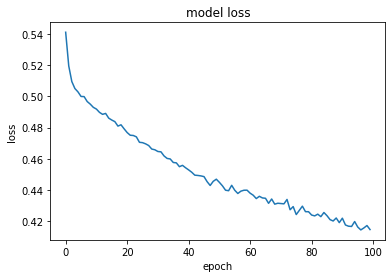

In [ ]:
fig, ax1 = plt.subplots()

# 모델의 오차를 그립니다.
ax1.plot(history.history['loss'])
ax1.set(title='model loss', xlabel='epoch', ylabel=
        'loss')

## Decision Tree

### 하이퍼 파라미터

- min_samples_split
  - 노드를 분할하기 위한 최소한의 샘플 데이터 수로 과적합 제어에 사용.
  - default는 2이다. 작게 설정할수록 분할되는 노드가 많아져 과적합 가능성 증가.
- min_samples_leaf
  - 말단 노드가 되기위한 최소한의 샘플 수
  - 과적합 제어 용도. 비대칭적 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있어 이 경우에는 작게 설정.
- max_features
  - 최적의 분할을 위해 고려할 최대 feature 개수. default는 None으로 데이터 세트의 모든 feature을 사용하여 분할.
  - int로 지정 시 대상 feature 개수, float로 지정 시 전체 feature중 대상 feature의 퍼센트
  - sqrt는 전체 feature중 제곱근 값.
  - auto는 sqrt와 동일
  - log는 전체 featur을 log2()로 선정
- max_depth
  - 트리의 최대 깊이 지정
  - default는 None. 이는 완벽히 클래스 결정값이 될때 까지 깊이를 계속 키우거나 노드가 가지는 데이터 개수가 min_samples_split보다 작아질 때 까지 계속 분할
  - 깊이가 깊어지면 min_samples_split 설정대로 최대 분할하여 과적합할 수 있으므로 적당한 값으로 제어.
- max_leaf_nodes
  - 말단 노드 최대 개수

- 출처: https://velog.io/@lsmmay322/%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%ACDecision-Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

ht_tree = DecisionTreeClassifier(max_depth=4,
                                 min_samples_leaf=6,
                                 random_state=123)
ht_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

In [ ]:
export_graphviz(ht_tree, out_file="tree.dot",
                class_names='FT',
                feature_names=X.columns,
                impurity=True, filled=True)

In [ ]:
!ls

drive  sample_data  tree.dot  tree.png	year0_without_TOTALC.csv


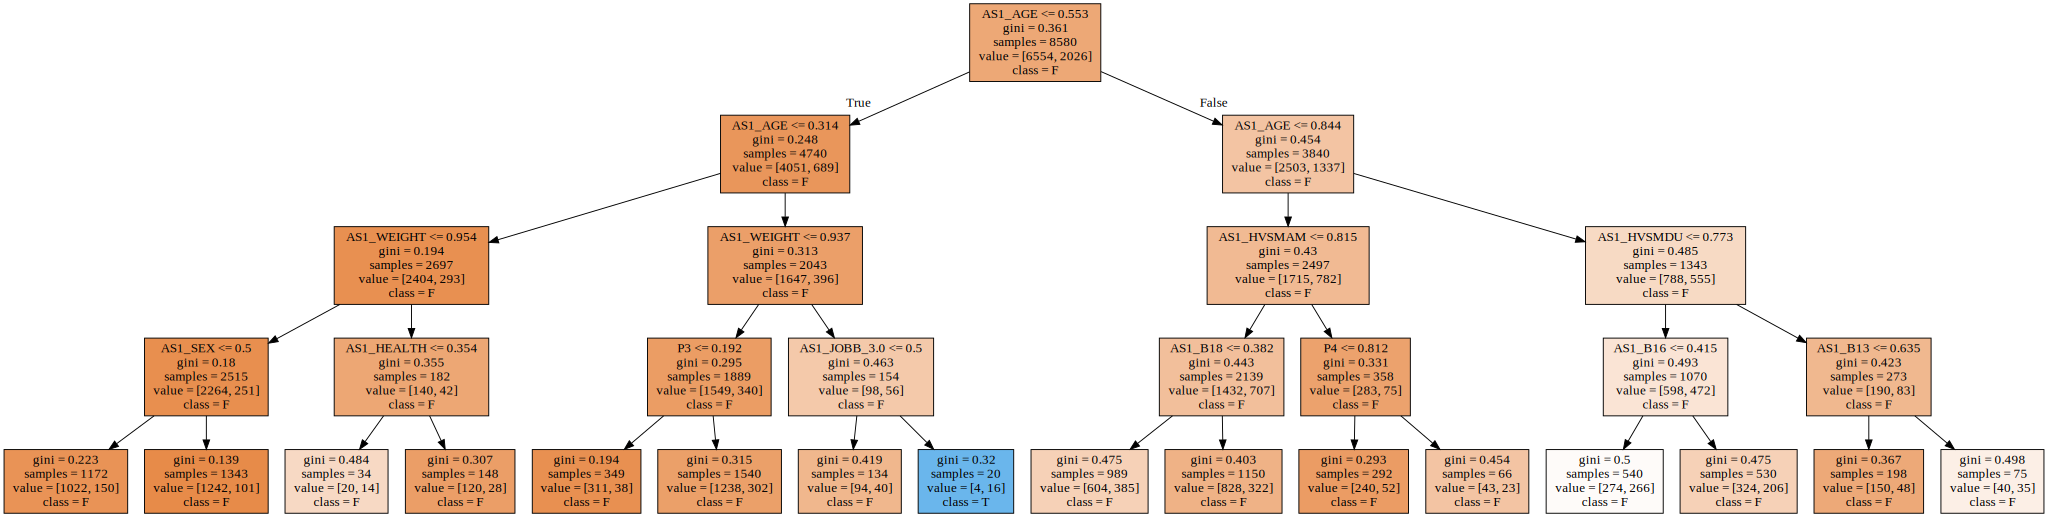

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='tree.png',format='png')

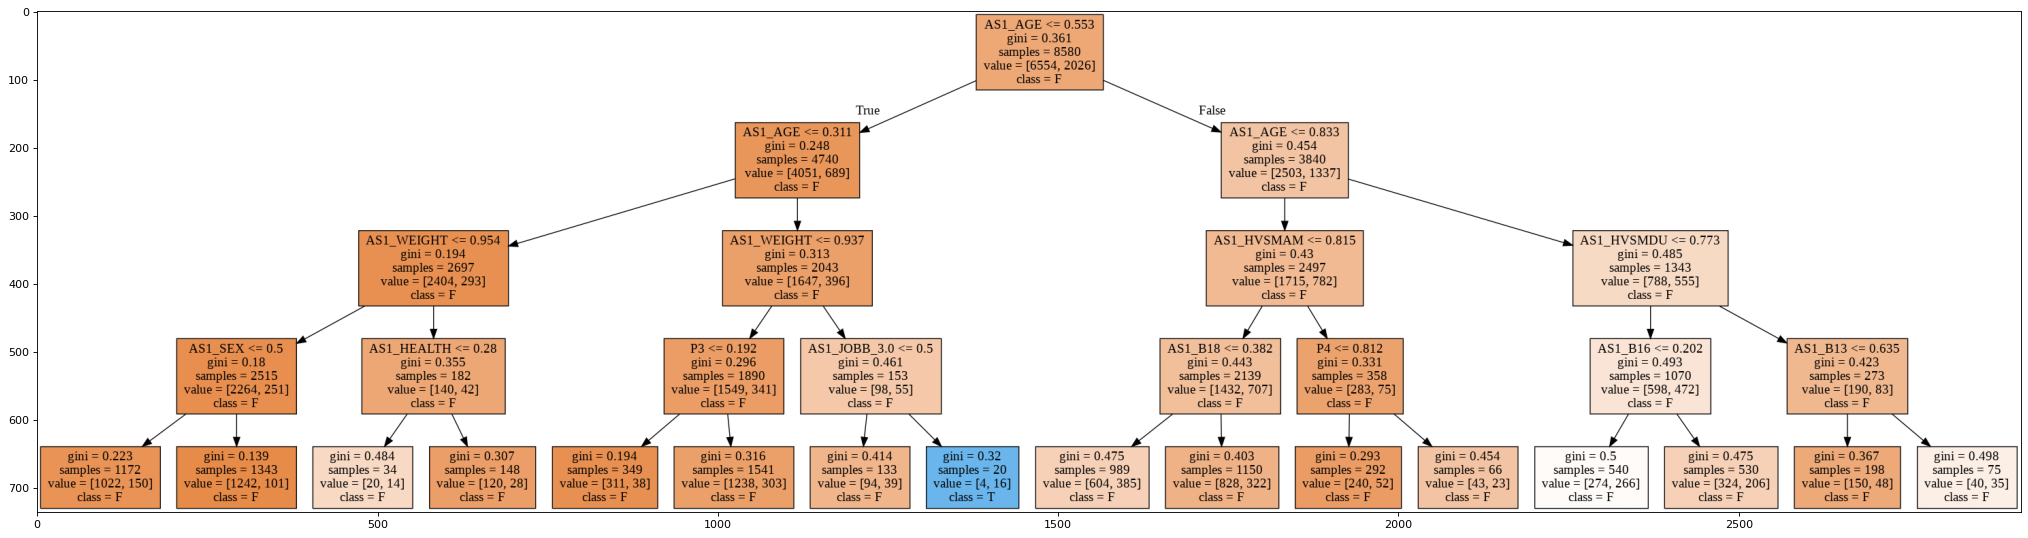

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(ht_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(ht_tree.score(X_test, y_test)))

importances = ht_tree.feature_importances_
print("특성 중요도:\n{}".format(importances))

훈련 세트 정확도: 0.765
테스트 세트 정확도: 0.763
특성 중요도:
[0.01211354 0.         0.         0.         0.         0.
 0.         0.03040771 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00951622 0.72567224 0.03121114 0.02840119
 0.         0.         0.         0.05359062 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01900378 0.
 0.         0.02006639 0.         0.04411863 0.         0.
 0.         0.         0.         0.         0.         0.01503837
 0.01086018]


Text(0, 0.5, 'feature importance')

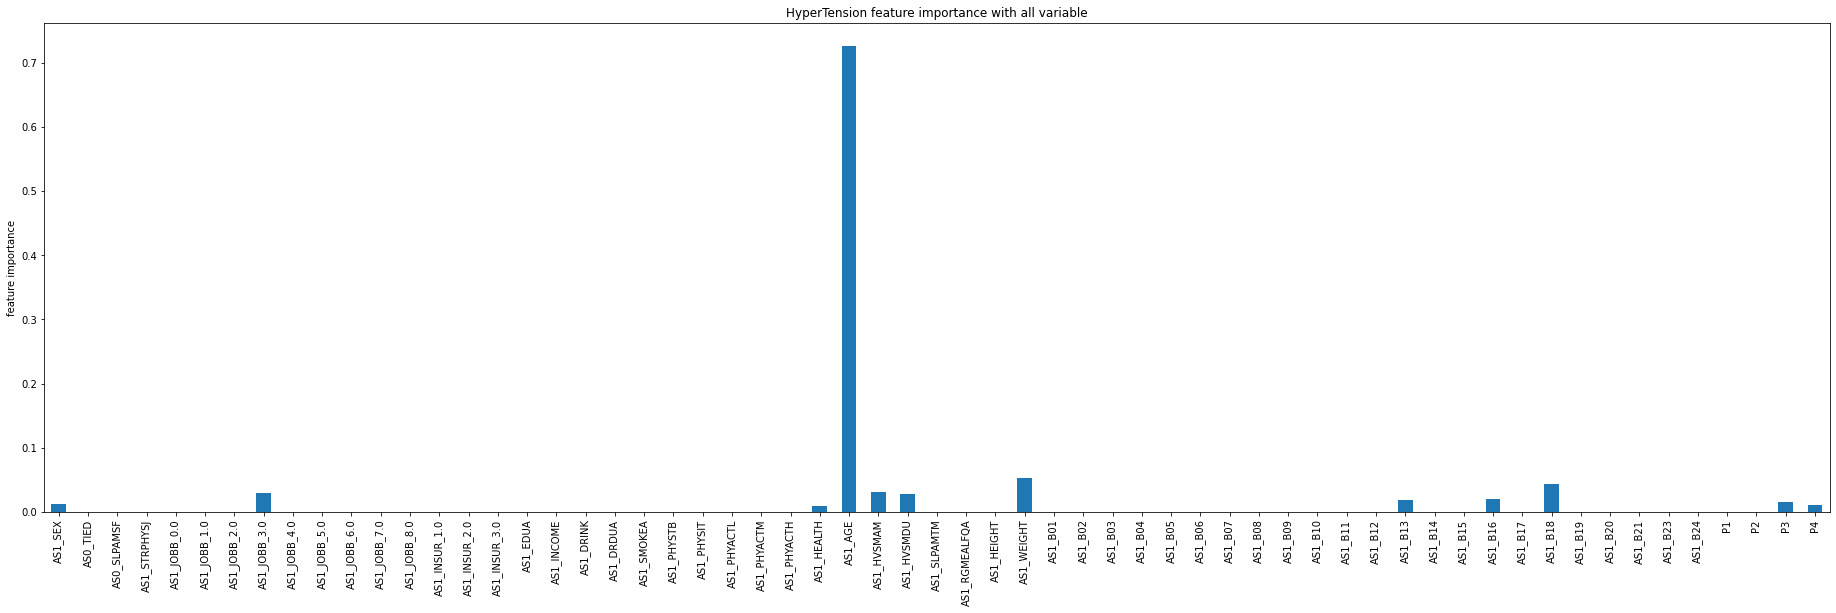

In [ ]:
# 특성 중요도 그래프

tree_importances = pd.Series(importances, index=X.columns)
fig, ax = plt.subplots(figsize=(32, 9))
tree_importances.plot.bar(ax=ax)
ax.set_title("HyperTension feature importance with all variable")
ax.set_ylabel("feature importance")